## Initial implementation

In [1]:
A = [1.0 0.0; 0.0 1.0; 0.0 -1.0]
B = [0.0 0.0; 1.0 1.0; 1.0 -1.0]

3×2 Array{Float64,2}:
 0.0   0.0
 1.0   1.0
 1.0  -1.0

In [2]:
function minkowskiAdd(A, B)
    res = zeros((size(A)[1]*size(B)[1], 2))
    n = 1
    for i = 1:size(A)[1]  # comment: you can use 1:size(A, 1) here
        for j = 1:size(B)[1] # comment: you can use 1:size(B, 1) here
            res[n,1] = A[i,1]+B[j,1]
            res[n,2] = A[i,2]+B[j,2]
            n += 1
        end
    end
    return res
end

minkowskiAdd (generic function with 1 method)

In [3]:
minkowskiAdd(A, B)

9×2 Array{Float64,2}:
 1.0   0.0
 2.0   1.0
 2.0  -1.0
 0.0   1.0
 1.0   2.0
 1.0   0.0
 0.0  -1.0
 1.0   0.0
 1.0  -2.0

## Using LazySets

In [4]:
using LazySets

In LazySets there is the `VPolygon` type which can be used to build a polygon in vertex representation.
For example, take the matrices $A$ and $B$ from the initial implementation, where each *row* corresponds to one
vertex of a polygon.

Below we use the programming construct that is called "list comprehension" to build the polygon:

In [5]:
P = VPolygon([A[i, :] for i in 1:size(A, 1)])

VPolygon{Float64}(Array{Float64,1}[[0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])

We do the same thing for `B`:

In [6]:
Q = VPolygon([B[i, :] for i in 1:size(A, 1)])

VPolygon{Float64}(Array{Float64,1}[[0.0, 0.0], [1.0, -1.0], [1.0, 1.0]])

Now we can plot these two:

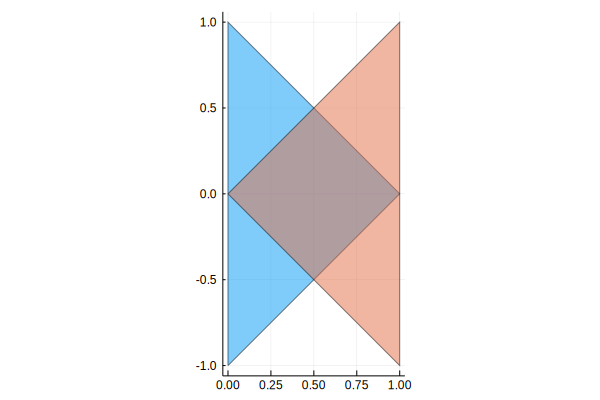

In [7]:
using Plots

plot(P)

plot!(Q) # use the bang operator (!) to put the new plot in the same graph as the previous one

We know that the minkowski sum of these two polygons is the set defined as

$$
 S = \{ p+q : p \in P, q \in Q\}.
$$

The idea in the function `minkowskiAdd` of the original implementation does precisely this calculation.

In [8]:
C = minkowskiAdd(A, B)

9×2 Array{Float64,2}:
 1.0   0.0
 2.0   1.0
 2.0  -1.0
 0.0   1.0
 1.0   2.0
 1.0   0.0
 0.0  -1.0
 1.0   0.0
 1.0  -2.0

Let us bring that matrix `C` into a polygon:

In [9]:
R = VPolygon([C[i, :] for i in 1:size(C, 1)])

VPolygon{Float64}(Array{Float64,1}[[0.0, -1.0], [1.0, -2.0], [2.0, -1.0], [2.0, 1.0], [1.0, 2.0], [0.0, 1.0]])

What happened here? It only has six vertices, instead of nine! Some vertices have misteriously "disappeared". Actually, the constructor of `VPolygon` is "smart" in the sense that it removes the redundant vertices automatically.

We can turn this option off to see:

In [10]:
R_redundant = VPolygon([C[i, :] for i in 1:size(C, 1)], apply_convex_hull=false)

VPolygon{Float64}(Array{Float64,1}[[1.0, 0.0], [2.0, 1.0], [2.0, -1.0], [0.0, 1.0], [1.0, 2.0], [1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [1.0, -2.0]])

As you can imagine, it is convenient that this option is `true` by default, since there is no interest in keeping redundant vertices, in general.

Then, it would be nice that our new concrete Minkowski sum function also removes redundant vertices by default. We consider this next.

One can always remove the repeated vertices using the convex hull function. There exist many cool algorithms for taking the convex hull operation.

In LazySets we have an algorithm for the convex hull in two dimensions that works quite well and is called
Andrew's monotone chain algorithm (see the [wikipedia page](https://en.wikipedia.org/wiki/Convex_hull_algorithms) for more information on convex hull algorithms).

For now we just want to modify `minkowskiAdd` such that it eliminates redundant vertices.

In [11]:
function minkowskiAdd_v2(A, B)
    res = zeros((size(A)[1]*size(B)[1], 2))
    n = 1
    for i = 1:size(A)[1]
        for j = 1:size(B)[1]
            res[n,1] = A[i,1]+B[j,1]
            res[n,2] = A[i,2]+B[j,2]
            n += 1
        end
    end
    
    # eliminate redundant vertices here
    res = convex_hull([res[i, :] for i in 1:size(C, 1)])
    
    # a rather advanced technical detail: now res is a list of vertices (vector of vectors)
    # you can transform it to a matrix as before with the following command
    # res = Matrix(hcat(C...)')
    # since we anyways need to pass the vector of vectors to the constructor of VPolygon,
    # i wont do this here

    # return the new res
    return res
end

minkowskiAdd_v2 (generic function with 1 method)

Let's try it!

In [12]:
C = minkowskiAdd_v2(A, B)

6-element Array{Array{Float64,1},1}:
 [0.0, -1.0]
 [1.0, -2.0]
 [2.0, -1.0]
 [2.0, 1.0] 
 [1.0, 2.0] 
 [0.0, 1.0] 

It has removed the redundant vertices. Now we would like to plot the result.

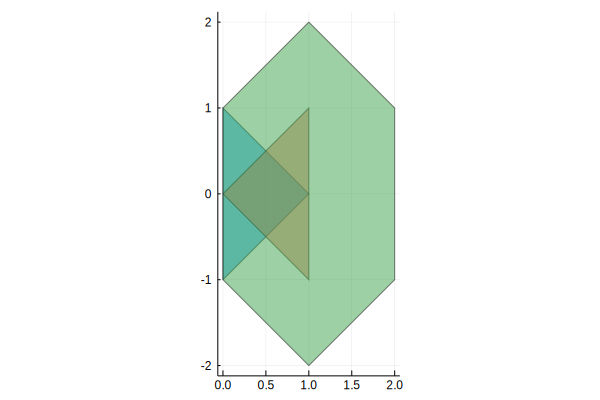

In [13]:
R = VPolygon(C)

plot!(R)

And that's the Minkowski sum!

Let us compare to the *lazy* Minkowski sum available in LazySets...

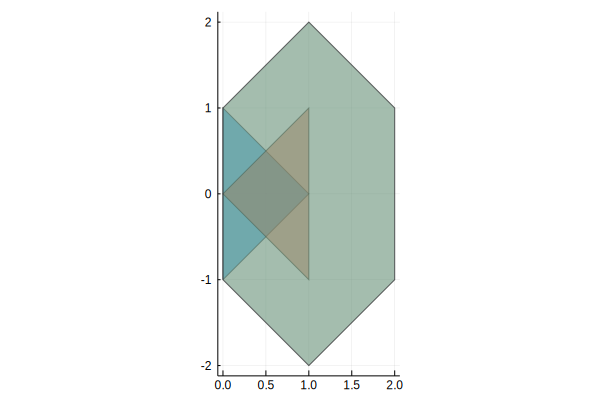

In [14]:
plot!(P ⊕ Q, alpha=.2)

They seem to match :) Very good.

## Next step

The next step is to make a new function `minkowski_sum` that takes as input two `VPolygon` and computes its concrete Minkowski sum. This is *not* implemented in LazySets and it is the purpose of the issue [LazySets#666](https://github.com/JuliaReach/LazySets.jl/issues/666).

In [15]:
minkowski_sum(P, Q)

MethodError: MethodError: no method matching minkowski_sum(::VPolygon{Float64}, ::VPolygon{Float64})

*Tip:* To write a function whose name already exists in a package (this is called *extending* a function) you have to do the following in Julia:

```julia
import LazySets: minkowski_sum

function minkowski_sum(P::VPolygon, Q::VPolygon)
    # add you new cool functionality here
    # . . .
end
```